In [10]:
#Installing prophet
!pip install prophet

In [12]:
#Importing Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.preprocessing import MinMaxScaler


In [13]:
#Loading Dataset
df = pd.read_csv("/content/yahoo_stock.csv")
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')
df.set_index('Date', inplace=True)

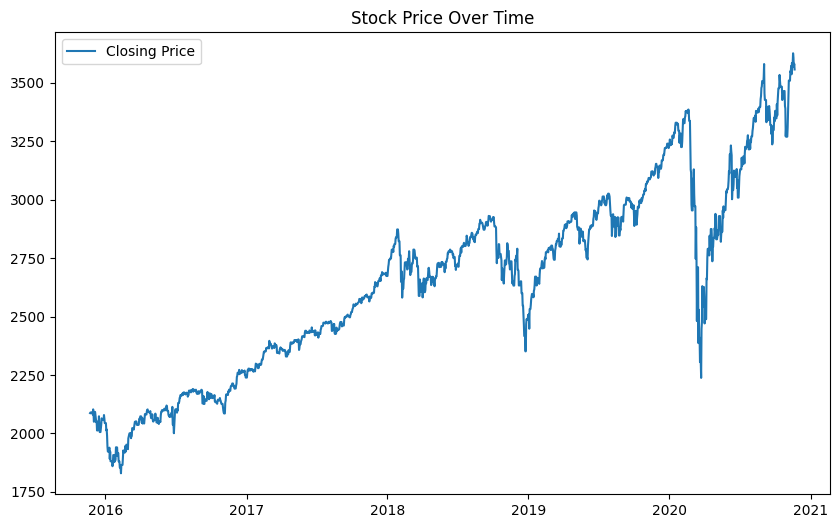

In [14]:
# Visualize Closing Price
plt.figure(figsize=(10, 6))
plt.plot(df['Close'], label='Closing Price')
plt.title("Stock Price Over Time")
plt.legend()
plt.show()

In [15]:
# Handle Missing Values
df.fillna(method='ffill', inplace=True)

# Split into Train and Test
data = df[['Close']]
train_size = int(len(data) * 0.8)
train, test = data.iloc[:train_size], data.iloc[train_size:]

/tmp/ipython-input-15-2139043512.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


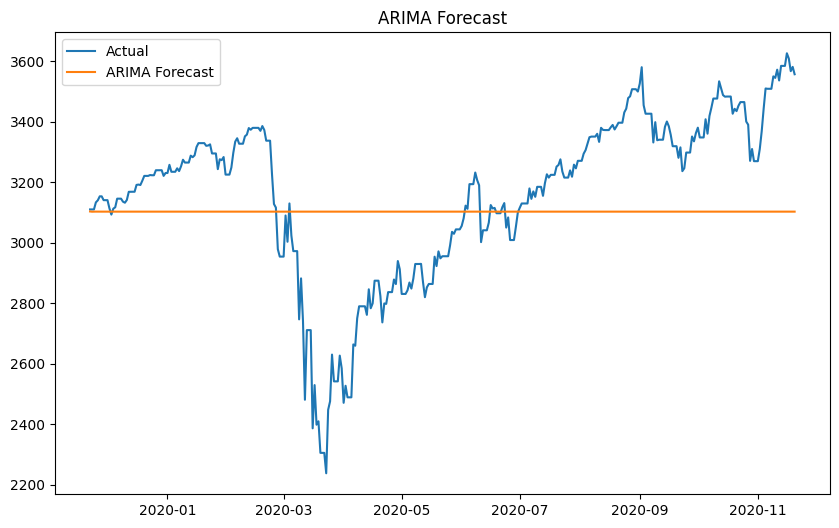

In [16]:
#Model 1:ARIMA
arima_model = ARIMA(train, order=(5,1,0))
arima_fit = arima_model.fit()
arima_forecast = arima_fit.forecast(steps=len(test))

# Plot ARIMA
plt.figure(figsize=(10, 6))
plt.plot(test.index, test['Close'], label="Actual")
plt.plot(test.index, arima_forecast, label="ARIMA Forecast")
plt.title("ARIMA Forecast")
plt.legend()
plt.show()

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg69blai3/gbz8_q5o.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg69blai3/15r0gqqi.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=37003', 'data', 'file=/tmp/tmpg69blai3/gbz8_q5o.json', 'init=/tmp/tmpg69blai3/15r0gqqi.json', 'output', 'file=/tmp/tmpg69blai3/prophet_modelo7rgpjzb/prophet_model-20250713153151.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:31:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:31:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


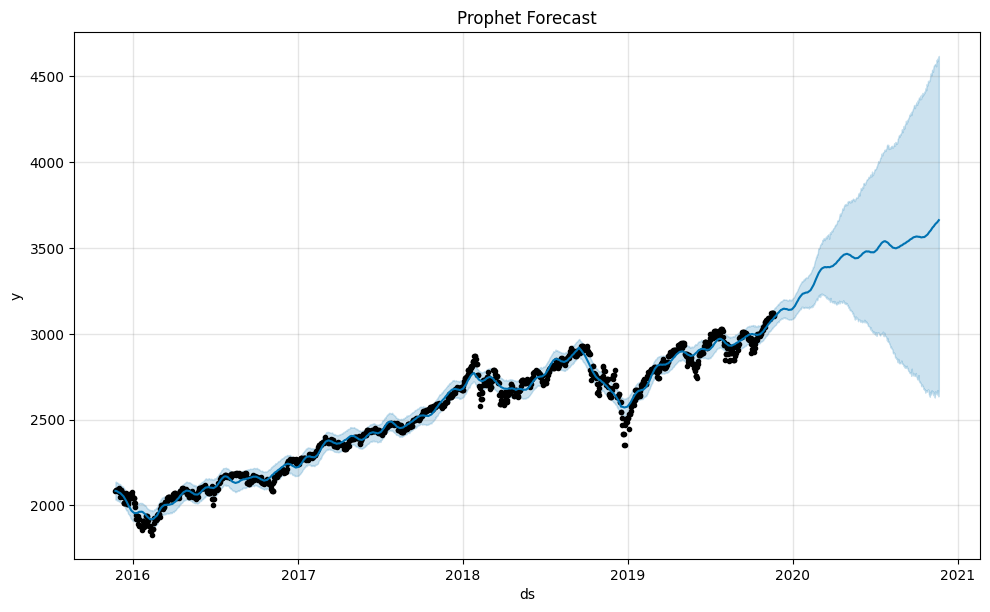

In [17]:
#Model2:Prophet
prophet_df = data.reset_index().rename(columns={"Date": "ds", "Close": "y"})
train_p = prophet_df.iloc[:train_size]
test_p = prophet_df.iloc[train_size:]

model_prophet = Prophet()
model_prophet.fit(train_p)

future = model_prophet.make_future_dataframe(periods=len(test))
forecast = model_prophet.predict(future)

# Plot Prophet
model_prophet.plot(forecast)
plt.title("Prophet Forecast")
plt.show()

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


44/44 ━━━━━━━━━━━━━━━━━━━━ 7s 74ms/step - loss: 0.0594
Epoch 2/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - loss: 0.0011
Epoch 3/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - loss: 5.0852e-04
Epoch 4/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - loss: 4.4081e-04
Epoch 5/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - loss: 4.8113e-04
Epoch 6/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 75ms/step - loss: 4.5470e-04
Epoch 7/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - loss: 4.2237e-04
Epoch 8/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - loss: 4.4847e-04
Epoch 9/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - loss: 4.3021e-04
Epoch 10/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - loss: 5.6079e-04
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step


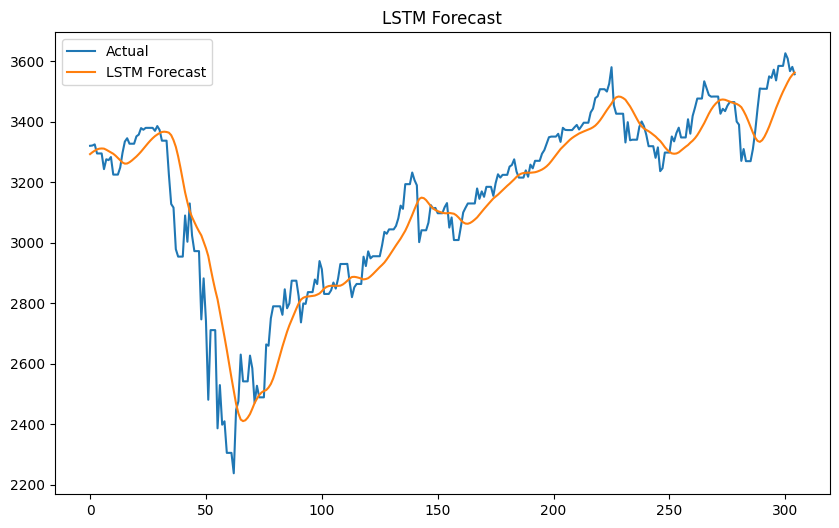

In [18]:
#Model3:LSTM
# Scale data
scaler = MinMaxScaler()
scaled = scaler.fit_transform(data)

train_scaled = scaled[:train_size]
test_scaled = scaled[train_size:]

# Create sequences
def create_seq(data, n_steps):
    X, y = [], []
    for i in range(n_steps, len(data)):
        X.append(data[i-n_steps:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

n_steps = 60
X_train, y_train = create_seq(train_scaled, n_steps)
X_test, y_test = create_seq(test_scaled, n_steps)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Build LSTM
model_lstm = Sequential()
model_lstm.add(LSTM(50, return_sequences=True, input_shape=(n_steps, 1)))
model_lstm.add(LSTM(50))
model_lstm.add(Dense(1))
model_lstm.compile(optimizer='adam', loss='mse')
model_lstm.fit(X_train, y_train, epochs=10, batch_size=32)

# Predict
lstm_pred = model_lstm.predict(X_test)
lstm_pred = scaler.inverse_transform(lstm_pred.reshape(-1, 1))
actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Plot LSTM
plt.figure(figsize=(10,6))
plt.plot(actual, label="Actual")
plt.plot(lstm_pred, label="LSTM Forecast")
plt.legend()
plt.title("LSTM Forecast")
plt.show()

In [19]:
# Evaluating all models
def evaluate(true, predicted, name="Model"):
    mae = mean_absolute_error(true, predicted)
    mse = mean_squared_error(true, predicted)
    rmse = np.sqrt(mse)
    print(f"\n{name} Evaluation:\nMAE: {mae:.3f} | MSE: {mse:.3f} | RMSE: {rmse:.3f}")


evaluate(test['Close'], arima_forecast, "ARIMA")
evaluate(test['Close'], forecast.iloc[-len(test):]['yhat'].values, "Prophet")
evaluate(actual, lstm_pred, "LSTM")


ARIMA Evaluation:
MAE: 228.095 | MSE: 77620.685 | RMSE: 278.605

Prophet Evaluation:
MAE: 284.588 | MSE: 145264.538 | RMSE: 381.136

LSTM Evaluation:
MAE: 77.677 | MSE: 11322.466 | RMSE: 106.407
